In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
plt.style.use('seaborn-v0_8-bright')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

import import_helper
import_helper.add_functions()
import neuruloid_segmentation.process_intensities as process
import neuruloid_segmentation.fitting_intensities as fit
import neuruloid_segmentation.utils as u

### Comparing 24 hour TBXT data profile from segmentation to simulations

Data are in "../processed_data"

We plot TBXT from triangle and square against modelling to show that the trend matches. 

['ctrl_250.csv', 'ctrl_350.csv', 'ctrl_500.csv']
20
38
100


(0.0, 100.0)

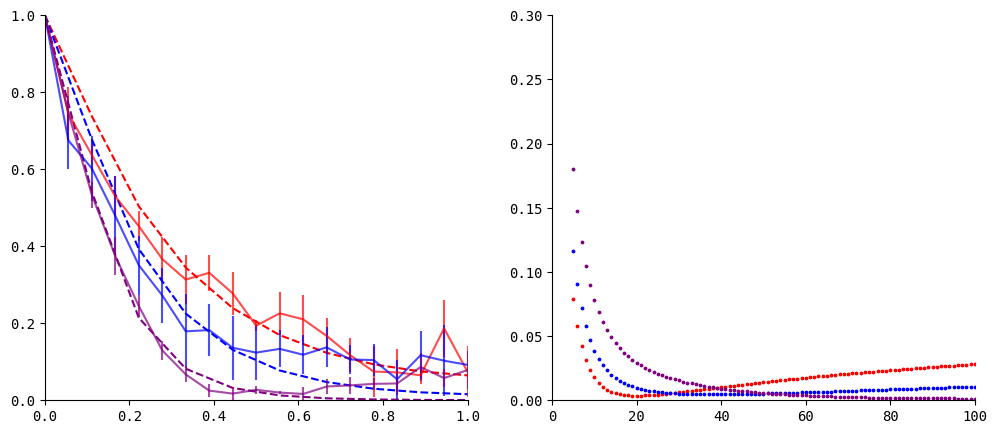

In [2]:
folder_path = "../processed_data/single_z_slices_24hr/circle_ctrl"

file_names_list = ["ctrl_250.csv", "ctrl_350.csv", "ctrl_500.csv"] # "ctrl_400.csv", 
print(file_names_list)
colors = ["red", "blue", "purple"] # "orange"
# colors = u.generate_colors(len(file_names_list))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# fig, ax2 = plt.subplots(1, 2, figsize=(12, 5))

for i in range(len(file_names_list)):
    file_path = os.path.join(folder_path, file_names_list[i])

    tbxt_dist, tbxt_intensity, tbxt_sd = fit.obtain_tbxt_data(file_path)

    simulation_dist, best_fit_intensity, best_fit_gamma, gamma_array, error_array = fit.fit_simulation(tbxt_dist, 
                                                                                                       tbxt_intensity)
    print(best_fit_gamma)
    ax[0].errorbar(tbxt_dist, 
                   tbxt_intensity, 
                   yerr=tbxt_sd, 
                   color=colors[i], 
                   alpha=0.7)
    # ax[0].plot(tbxt_dist, tbxt_intensity, color=colors[i], alpha=0.7)
    # ax[0].fill_between(tbxt_dist, 
    #                    tbxt_intensity+tbxt_sd, 
    #                    tbxt_intensity-tbxt_sd, 
    #                    color=colors[i], 
    #                    alpha=0.1)
    ax[0].plot(simulation_dist, 
               best_fit_intensity, 
               color=colors[i], 
               linestyle="--", 
               label=file_names_list[i])
    ax[1].scatter(gamma_array, error_array, color=colors[i], s=3)

ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 1)
ax[1].set_ylim(0, 0.3)
ax[1].set_xlim(0, 100)

In [3]:
# load reaction-diffusionsimulation data
simulation_file_path = "../processed_data/rd_simulations/simulation_intensity_circle.csv"
simulation_data = pd.read_csv(simulation_file_path)
simulation_distance = np.linspace(0, 1, 10)

### Fit each circular data separately and find relation with $\gamma$

We fit parameter $\gamma$ for TBXT of circular neuruloids of different sizes separately for each sizes.

This is then applied to triangle and square neuruloid data with the same params.

In [4]:
FOLDER = "../intensity_data"
subfolder = "single_z_slices_24hr/circle_ctrl/"

data_folder_path = os.path.join(FOLDER, subfolder)

data_names_sizes = {"ctrl_250":250, "ctrl_350":350, 
                    "ctrl_400":400, "ctrl_500":500}
data_color = {"ctrl_250":"red", "ctrl_350":"blue", 
              "ctrl_400":"green", "ctrl_500":"purple"}

#sorted(os.listdir(data_folder_path))

fitted_gamma = []
diameter_size = []
sample_name_list = []
data_color_list = []

for data_name in list(data_names_sizes.keys()):

    sample_names = os.listdir(os.path.join(data_folder_path, data_name))
    fitted_gamma_array = np.zeros(len(sample_names))

    for i in range(len(sample_names)):

        df = pd.read_csv(os.path.join(f"{data_folder_path}/{data_name}", sample_names[i]))
        discrete_dist = np.linspace(0, np.max(df["distance"].to_numpy()), 20)
        normalise_max_df = process.process_raw_to_norm_dataframe(df,
                                                                discrete_dist,
                                                                channels=[3],
                                                                subtract_bg=[True])
        tbxt_dist = discrete_dist[1:] / np.max(discrete_dist)

        tbxt_intensity = normalise_max_df["channel_3"].to_numpy()
        simulation_dist, best_fit_intensity, best_fit_gamma, gamma_array, error_array = fit.fit_simulation(tbxt_dist, 
                                                                                                           tbxt_intensity)
        fitted_gamma.append(best_fit_gamma)
        diameter_size.append(data_names_sizes[data_name])
        sample_name_list.append(sample_names[i])
        data_color_list.append(data_color[data_name])
    

In [5]:
area = (np.array(diameter_size)/100)**2
gamma = np.array(fitted_gamma)
slope, r_squared = u.fit_proportional_line_and_evaluate(area, gamma)
print(f"Slope is {slope}, with R-squared {r_squared}.")

Slope is 2.327711280377221, with R-squared 0.587168199285123.


(0.0, 70.0)

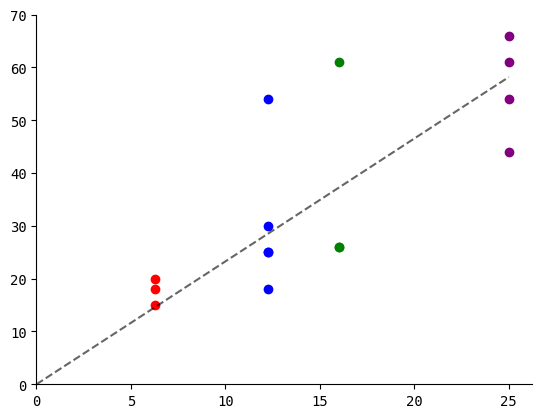

In [6]:
# plot linear line
fig, ax = plt.subplots()
for i in range(len(sample_name_list)):
    ax.scatter(area[i], gamma[i], label=sample_name_list[i], c=data_color_list[i])

x = np.linspace(0, 25, 10)
y = slope * x 

ax.plot(x, y, color="black", linestyle="--", alpha=0.6)
ax.set_xlim(0)
ax.set_ylim(0, 70)
# ax.set_ylabel("Fitted Length Scale Parameter with RD model")
# ax.set_xlabel("Diameter(10$^2$micron)$^2$")
# ax.legend(fontsize=7, bbox_to_anchor=(1, 1))


In [7]:
# GET THE MSE VALUES
FOLDER = "../intensity_data"
subfolder = "single_z_slices_24hr/circle_ctrl/"

data_folder_path = os.path.join(FOLDER, subfolder)
data_names_sizes = {"ctrl_250":250, "ctrl_350":350, 
                    "ctrl_400":400, "ctrl_500":500}

mse_list = []

for data_name in list(data_names_sizes.keys()):

    sample_names = os.listdir(os.path.join(data_folder_path, data_name))
    mse_array = np.zeros(len(sample_names))
    for i in range(len(sample_names)):

        df = pd.read_csv(os.path.join(f"{data_folder_path}/{data_name}", sample_names[i]))
        discrete_dist = np.linspace(0, np.max(df["distance"].to_numpy()), 20)
        normalise_max_df = process.process_raw_to_norm_dataframe(df,
                                                                discrete_dist,
                                                                channels=[3],
                                                                subtract_bg=[True])
        tbxt_dist = discrete_dist[1:] / np.max(discrete_dist)

        tbxt_intensity = normalise_max_df["channel_3"].to_numpy()
        simulation_dist, best_fit_intensity, best_fit_gamma, gamma_array, error_array = fit.fit_simulation(tbxt_dist, 
                                                                                                           tbxt_intensity)
        mse_array[i] = np.min(error_array)
    mse_list.append(mse_array)

In [8]:
mse_for_each_diameter = np.array([np.mean(mse_list[i]) for i in range(len(mse_list))])
print(mse_for_each_diameter)
np.save("mse_for_rd_fitted_tbxt.npy", mse_for_each_diameter)

[0.00356147 0.0052757  0.00472212 0.00431884]


Text(0, 0.5, 'Mean Squared Error')

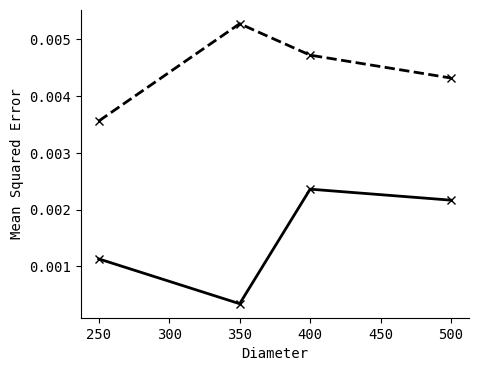

In [9]:
mse_mcmc_path = "../../reaction_diffusion_neuruloid/notebooks/mse_for_mcmc_fitted_tbxt.npy"
mse_rd_path = "mse_for_rd_fitted_tbxt.npy"
mse_mcmc = np.load(mse_mcmc_path)
mse_rd = np.load(mse_rd_path)

fig = plt.figure(figsize=(5, 4))
diameters = [250, 350, 400, 500]
plt.plot(diameters, mse_mcmc, marker="x", linestyle="-", linewidth=2, label="Two-step_model", color="black")
plt.plot(diameters, mse_rd, marker="x", linestyle="--", linewidth=2, label="Reaction-diffusion model only", color="black")
# plt.legend(loc="lower right")
plt.xlabel("Diameter")
plt.ylabel("Mean Squared Error")

#### Plot fitted parameters with TBXT intensities from neuruloids of various geometries and sizes

['triangle_ctrl_350_channel_3.csv', 'triangle_ctrl_500_channel_3.csv']
[24, 50]


(0.0, 1.0)

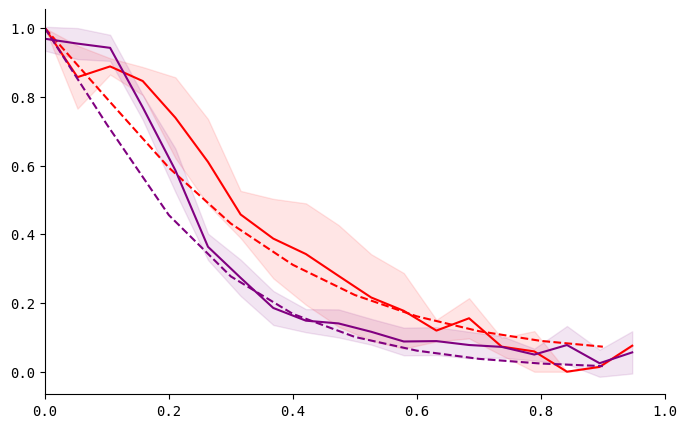

In [10]:
# DATA FOLDER
DATA_FOLDER = "../processed_data"
subfolder = "single_z_slices_24hr/triangle_ctrl"
data_folder_path = os.path.join(DATA_FOLDER, subfolder)
diameter_to_plot = [350, 500]
colors = ["red", "purple"]
data_names = [f"triangle_ctrl_{diameter_to_plot[i]}_channel_3.csv" for i in range(len(diameter_to_plot))] # channel 3 for TBXT only
print(data_names)

# SIMULATION FOLDER
simulation_folder = os.path.join(DATA_FOLDER, "rd_simulations")
simulation_file_path = os.path.join(simulation_folder, "simulation_intensity_triangle.csv")
simulation_dataframe = pd.read_csv(simulation_file_path)
gamma_fitted = [int(2*(diameter_to_plot[i]/100)**2) for i in range(len(diameter_to_plot))]
print(gamma_fitted)

fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(data_names)):
    neuruloid_df = pd.read_csv(os.path.join(data_folder_path, data_names[i]))
    neuruloid_dist = neuruloid_df["distance"].to_numpy() / np.max(neuruloid_df["distance"].to_numpy())
    neuruloid_mean = neuruloid_df["mean"].to_numpy()
    neuruloid_sd = neuruloid_df["sd"].to_numpy()
    ax.plot(neuruloid_dist, neuruloid_mean, color=colors[i])
    ax.fill_between(neuruloid_dist, 
                    neuruloid_mean-neuruloid_sd, 
                    neuruloid_mean+neuruloid_sd, 
                    color=colors[i], 
                    alpha=0.1)
    
    simulation_intensity = simulation_dataframe[f"gamma{gamma_fitted[i]}"].to_numpy()
    simulation_dist = np.linspace(0, 1, len(simulation_intensity)+1)[:-1]
    ax.plot(simulation_dist, simulation_intensity, color=colors[i], linestyle="--")

# ax[i].set_title(f"{data_name}, n={n}") 
ax.set_xlim(0,1)
# ax.set_xlabel("Distance from edge (microns)")
# ax.set_ylabel("Normalised Intensity")